In [ ]:
# all this does is the network differentiation.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import pandas as pd
import networkx as nx

from matplotlib.gridspec import GridSpec

In [2]:
# load the reference network
ref_network = np.load('reference_network.npz')
print('files:', ref_network.files)


files: ['pos', 'metabolites', 'adj']


In [8]:

def np_conf(_binarized, _ref):
    tp = (_binarized * _ref).sum()
    fn = (~_binarized * _ref).sum()
    fp = (_binarized * ~_ref).sum()
    tn = (~_binarized * ~_ref).sum()
    return tn, fp, fn, tp

def my_f1(tn, fp, fn, tp):
    num = 2 * tp
    denom = (2*tp) + fp + fn
    return num/denom

def get_optimal_value_coarse_np(y_pred, y_true, resolution = 1000):
    # prepare
    y_true = y_true.flatten()
    y_true = y_true.astype(bool)
    y_pred = y_pred.flatten()
    v_min, v_max = y_pred.min(), y_pred.max()

    # loop through threshold ranges
    result = np.zeros((resolution,2))
    for idx, _threshold in enumerate(np.linspace(v_min,v_max,resolution)):
        _binarized = (y_pred > _threshold)
        tn, fp, fn, tp = np_conf(_binarized, y_true)
        
        _f1 = my_f1(tn, fp, fn, tp)
        result[idx] = _f1, _threshold

    # returns the score and the threshold
    return result[np.argmax(result[:,0])]


## split the differentiation

In [4]:
ref_network = np.load('reference_network.npz')

metabolites = list(ref_network['metabolites'])

In [5]:
# load the inferred network data
disease_clrp = np.load('some_path_to_data/disease_inferred.npy') # clr_p 200 samples
healthy_clrp = np.load('some_path_to_data/healthy_inferred.npy') # clr_p 200 samples

In [6]:
def calc_bin_network(predicted_matrix, ref_adj_matrix):
    # predicted_matrix is an array
    # ref_matrix is used to calculate optimal thresholds
    # ref_values is a dict of pre-computed values
    # metrics is a list of centrality measures
    
    # prepare things
    _original_shape = predicted_matrix.shape
    ref_adj_matrix = ref_adj_matrix.flatten()
    predicted_matrix = predicted_matrix.flatten()

    # get threshold for binarized results
    _, threshold = get_optimal_value_coarse_np(y_pred = abs(predicted_matrix),
                                               y_true = ref_adj_matrix,
                                               resolution = 100) # this resolution is probably fine.
    _rep_binarized = abs(predicted_matrix) > threshold
    _rep_binarized = _rep_binarized.reshape(_original_shape)
    return _rep_binarized

In [9]:
# ---------------
# control for noise by comparing to self
# ---------------

# compare within healthy, first 50 vs second 50

bin_healthy_first = np.zeros((50,83,83))
for idx, _sample in enumerate(healthy_clrp[:50]):
    bin_healthy_first[idx] = calc_bin_network(_sample,
                                        ref_adj_matrix = ref_network['adj'])

bin_healthy_second = np.zeros((50,83,83))
for idx, _sample in enumerate(healthy_clrp[50:]):
    bin_healthy_second[idx] = calc_bin_network(_sample,
                                        ref_adj_matrix = ref_network['adj'])

# ----- disease set -------
bin_disease_first = np.zeros((50,83,83))
for idx, _sample in enumerate(disease_clrp[:50]):
    bin_disease_first[idx] = calc_bin_network(_sample,
                                        ref_adj_matrix = ref_network['adj'])

bin_disease_second = np.zeros((50,83,83))
for idx, _sample in enumerate(disease_clrp[50:]):
    bin_disease_second[idx] = calc_bin_network(_sample,
                                        ref_adj_matrix = ref_network['adj'])

# flatten down. edges based on being in >50% of networks
bin_disease_first = (bin_disease_first.sum(axis=0)/50 > 0.5).astype(float)
bin_disease_second = (bin_disease_second.sum(axis=0)/50 > 0.5).astype(float)

bin_healthy_first = (bin_healthy_first.sum(axis=0)/50 > 0.5).astype(float)
bin_healthy_second = (bin_healthy_second.sum(axis=0)/50 > 0.5).astype(float)

In [10]:
# difference between healthy and diseased
diff = bin_healthy_first - bin_disease_first

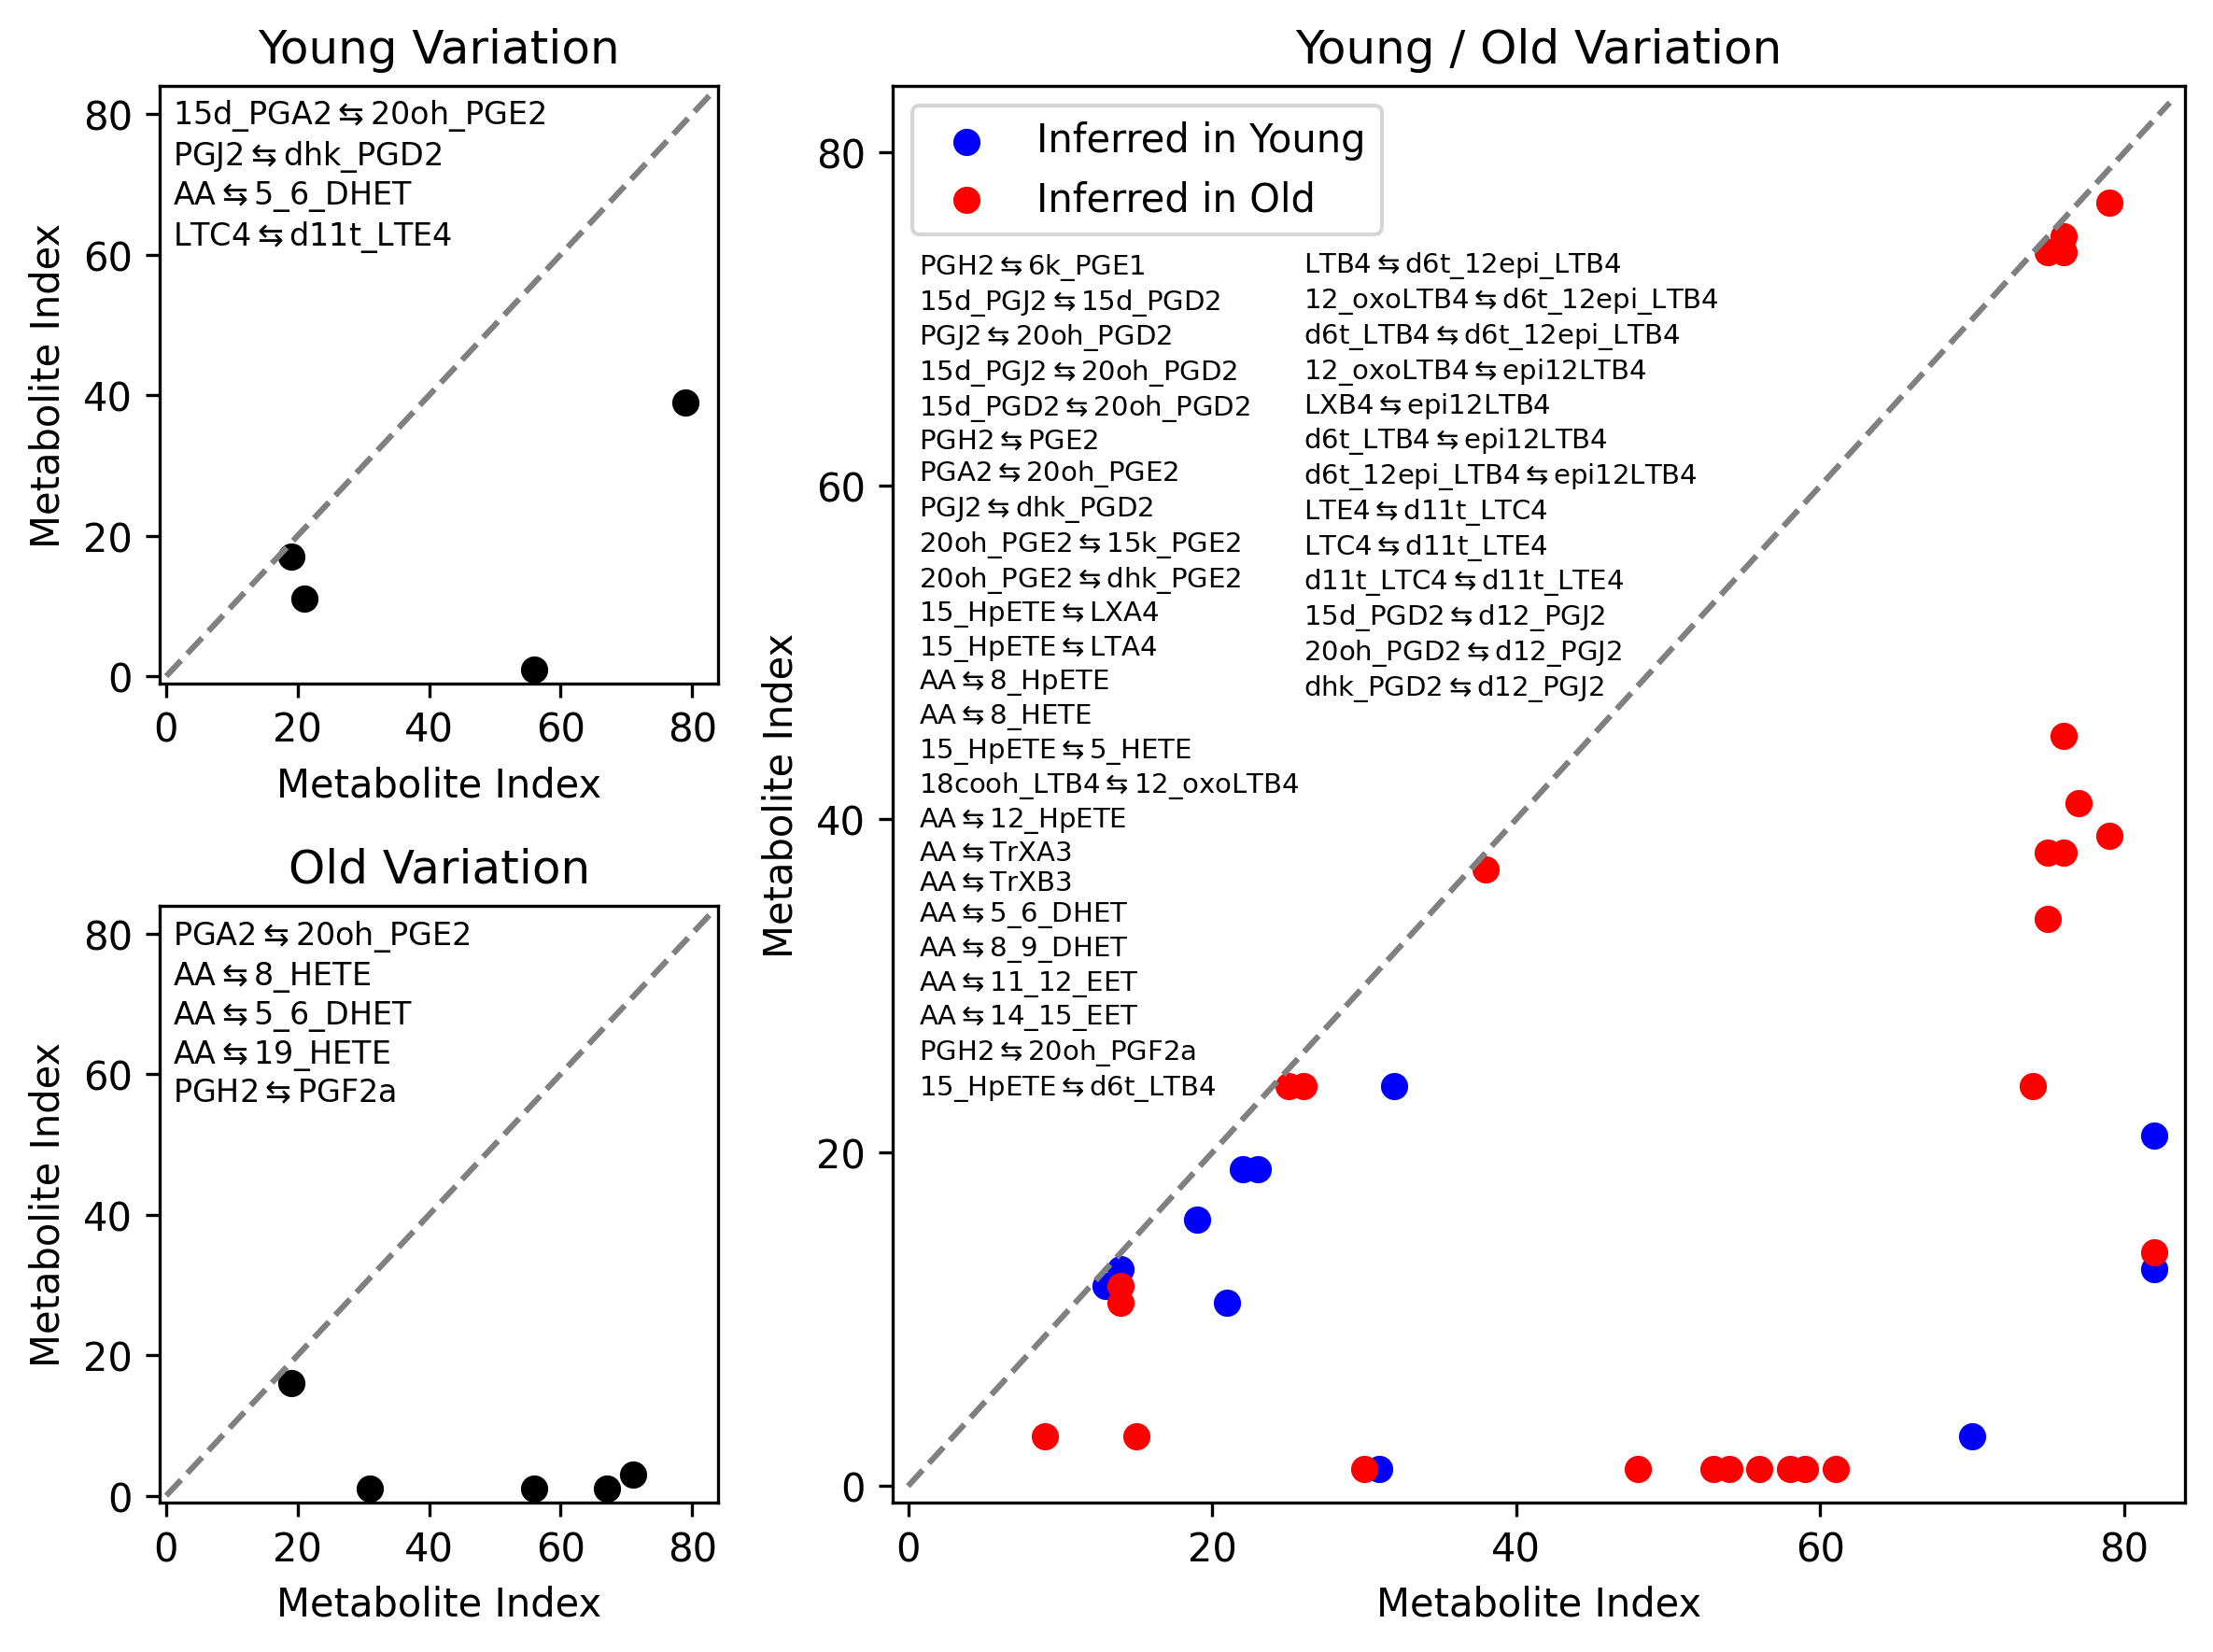

In [11]:
# visualize

fig = plt.figure(figsize=(8,6),dpi=300)
gs = GridSpec(2,3,figure=fig)

ax0 = fig.add_subplot(gs[0,0]) # 
temp = np.where(abs(bin_healthy_first-bin_healthy_second)>0)
ax0.scatter(*temp, c='k')
ax0.set_xlabel('Metabolite Index')
ax0.set_ylabel('Metabolite Index')
ax0.set_title('Young Variation')
ax0.set_xticks([0,20,40,60,80])
ax0.set_yticks([0,20,40,60,80])
ax0.set_xlim(-1,84)
ax0.set_ylim(-1,84)
ax0.plot([0,83],[0,83],ls='--',c='gray')
diff = abs(bin_healthy_first-bin_healthy_second)
temp_text = ''
for _xmet, _ymet in zip(*np.where(diff > 0.)): # edges that are different between runs
    temp_text += metabolites[_ymet]+ '$\\leftrightarrows$'+ metabolites[_xmet]+ '\n'
ax0.text(x = 1,
         y = 56,
         s = temp_text, fontdict={'fontsize':8})

ax1 = fig.add_subplot(gs[1,0])
temp = np.where(abs(bin_disease_first-bin_disease_second)>0)
ax1.scatter(*temp, c='k')
ax1.set_xlabel('Metabolite Index')
ax1.set_ylabel('Metabolite Index')
ax1.set_title('Old Variation')
ax1.set_xticks([0,20,40,60,80])
ax1.set_yticks([0,20,40,60,80])
ax1.set_xlim(-1,84)
ax1.set_ylim(-1,84)
ax1.plot([0,83],[0,83],ls='--',c='gray')
diff = abs(bin_disease_first-bin_disease_second)
temp_text = ''
for _xmet, _ymet in zip(*np.where(diff > 0.)): # edges that are different between runs
    temp_text += metabolites[_ymet]+ '$\\leftrightarrows$'+ metabolites[_xmet]+ '\n'
ax1.text(x = 1,
         y = 51,
         s = temp_text, fontdict={'fontsize':8})

diff = bin_healthy_first - bin_disease_first
ax2 = fig.add_subplot(gs[0:2,1:])
blue = ax2.scatter(*np.where(diff>0),c='b')
red = ax2.scatter(*np.where(diff<0),c='r')
ax2.set_xticks([0,20,40,60,80])
ax2.set_yticks([0,20,40,60,80])
ax2.set_xlim(-1,84)
ax2.set_ylim(-1,84)
ax2.set_xlabel('Metabolite Index')
ax2.set_ylabel('Metabolite Index')
ax2.set_title('Young / Old Variation')
ax2.plot([0,83],[0,83],ls='--',c='gray')
ax2.legend([blue, red],['Inferred in Young','Inferred in Old'])

#
temp_text = ''
for _xmet, _ymet in zip(*np.where(abs(diff) > 0.)): # edges that are different between runs
    temp_text += metabolites[_ymet]+ '$\\leftrightarrows$'+ metabolites[_xmet]+ '\n'

ax2.text(x = 0.7,
         y = 23.5,
         s = '\n'.join(temp_text.split('\n')[:25]), fontdict={'fontsize':7})
ax2.text(x = 26,
         y = 45.5,
         s = '\n'.join(temp_text.split('\n')[25:]), fontdict={'fontsize':7})
plt.tight_layout()

# save figure to some location
# fig.savefig('some_path_to_figures/appendix_differentiation.png')


In [ ]:
# place these difference of edges on a graph

In [12]:
graph = nx.from_numpy_array(bin_healthy_first-bin_disease_first)

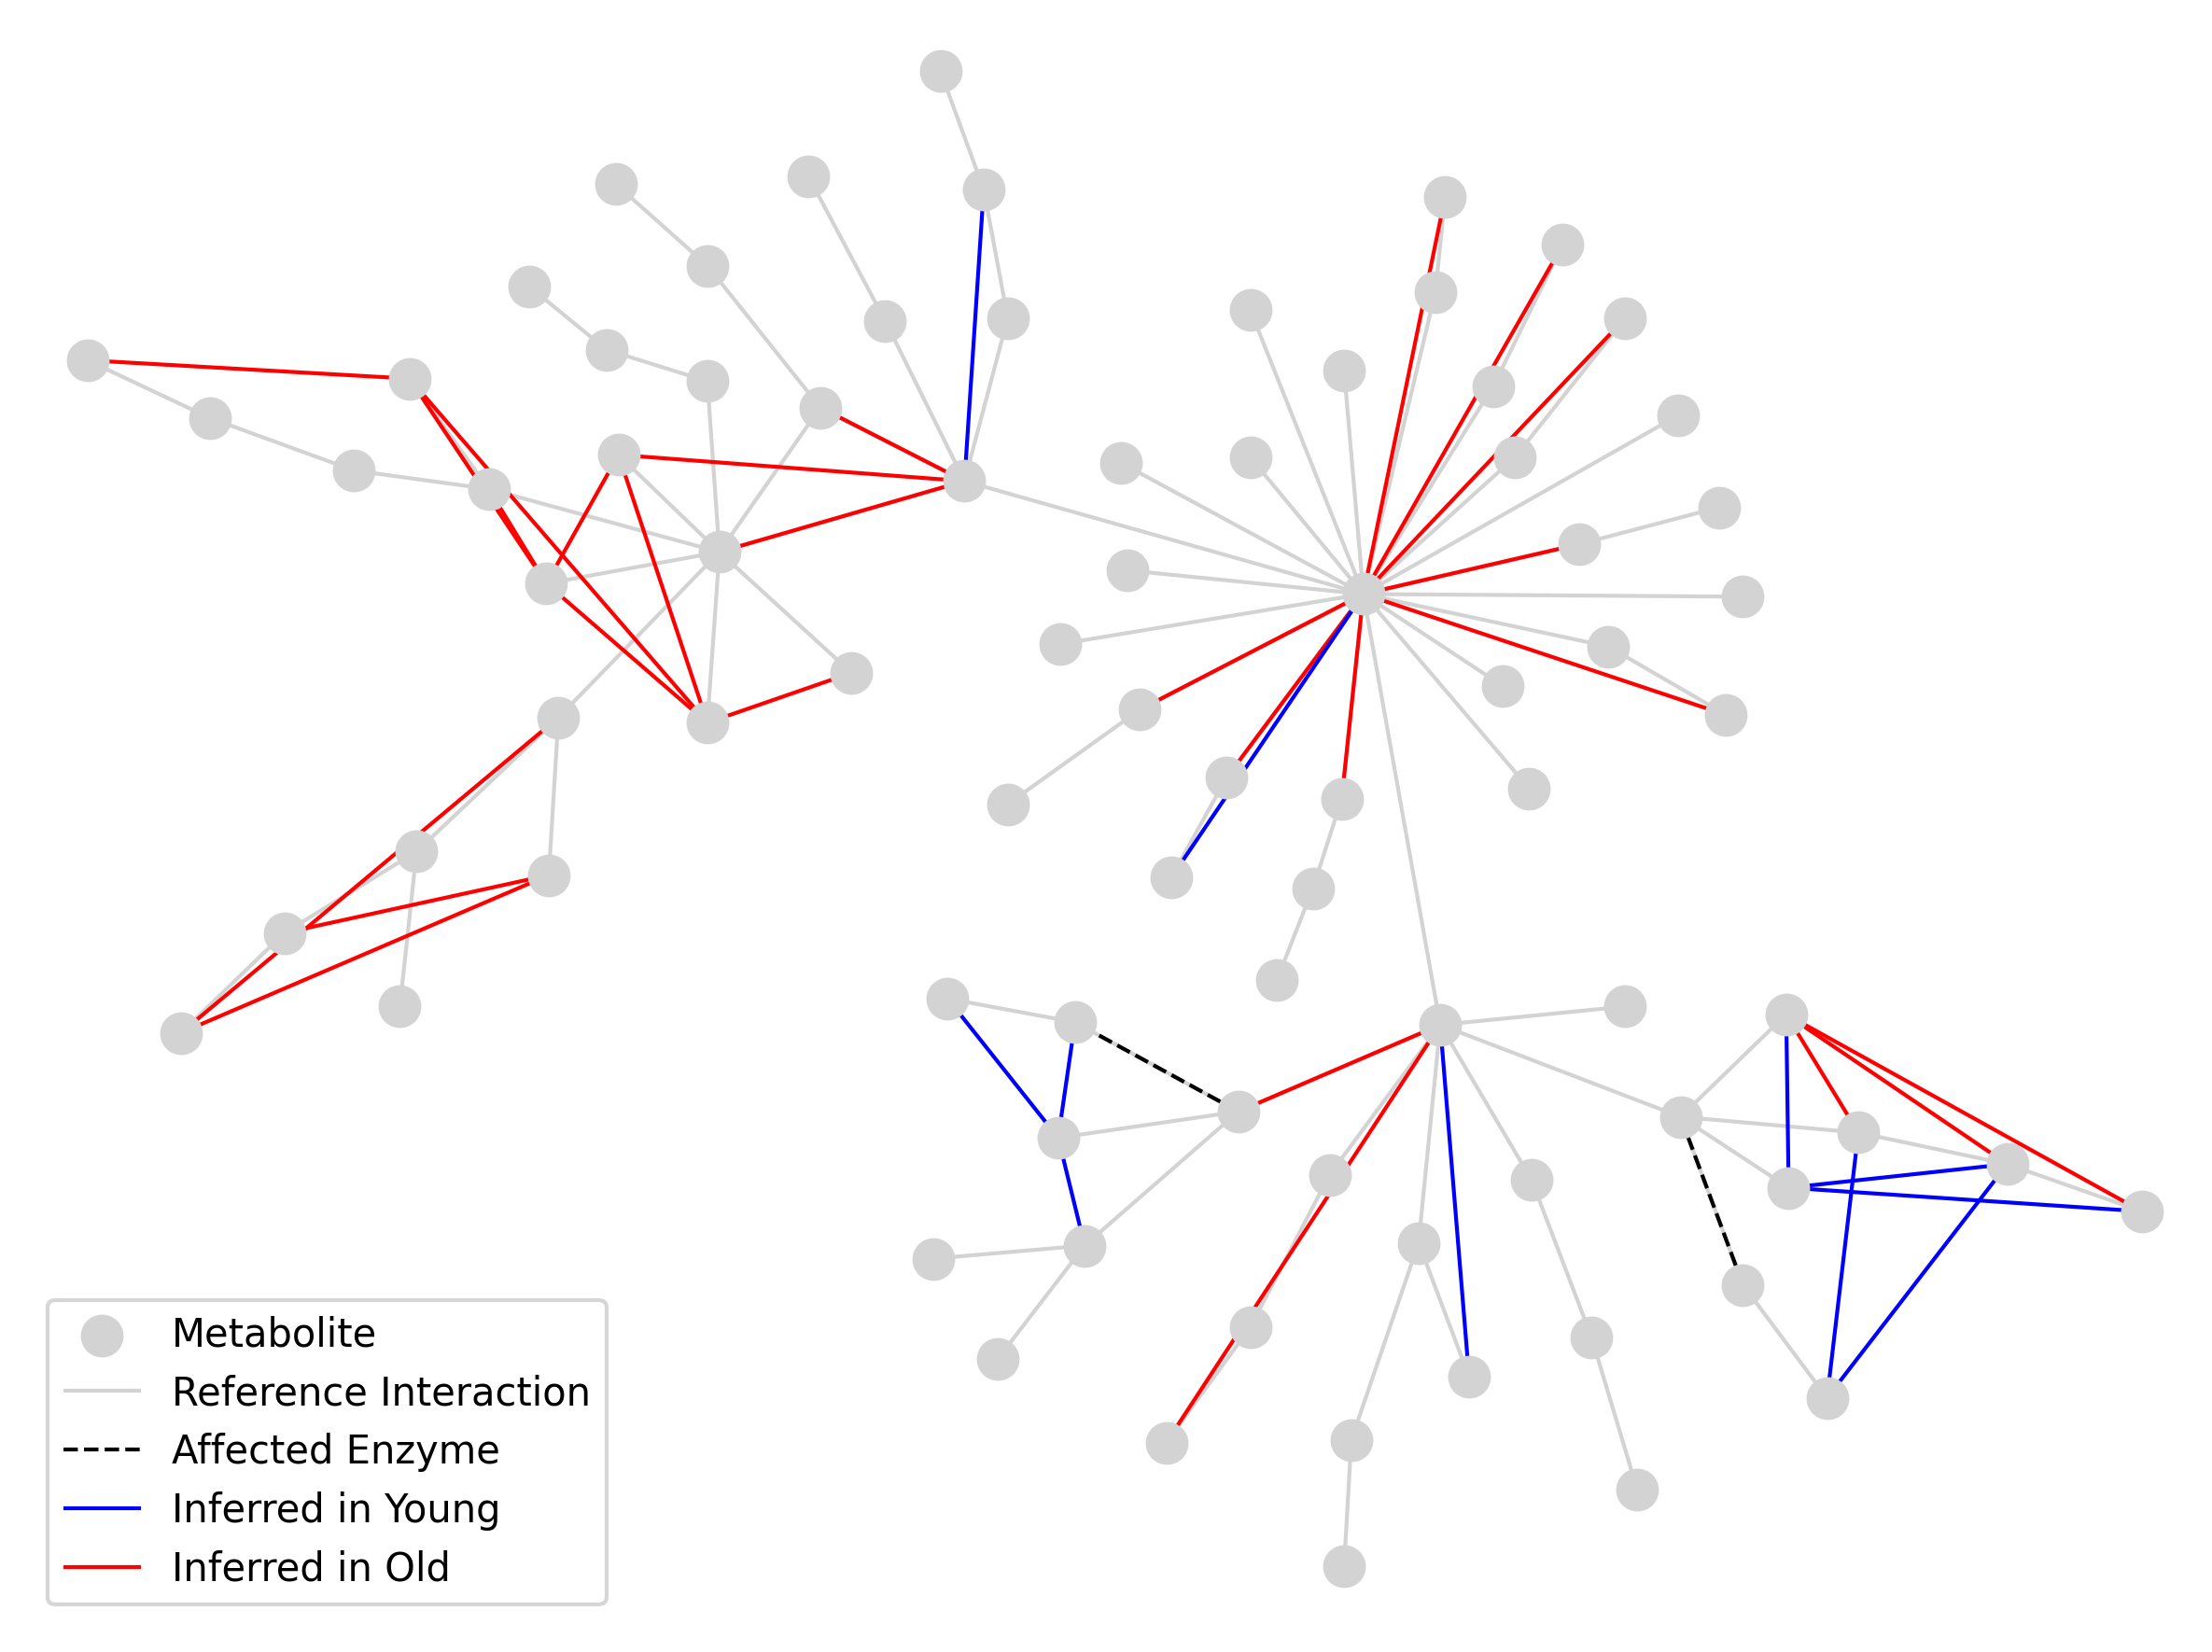

In [14]:

fig = plt.figure(figsize=(8,6),dpi=300)
# underlying network
metabolites_label = nx.draw_networkx_nodes(graph, pos=ref_network['pos'], node_size=100, node_color='lightgray')
reference_edges_label = nx.draw_networkx_edges(nx.from_numpy_array(ref_network['adj']), pos=ref_network['pos'], edge_color='lightgray')

# enzyme edges
enzyme_edges = np.zeros((83,83))
enzyme_edges[np.where(np.array(metabolites) == 'PGE2')[0][0], np.where(np.array(metabolites) == '15k_PGE2')[0][0]] = 1
enzyme_edges[np.where(np.array(metabolites) == 'PGD2')[0][0], np.where(np.array(metabolites) == '15k_PGD2')[0][0]] = 1
enzyme_graph = nx.from_numpy_array(enzyme_edges)
enzyme_edges_label = nx.draw_networkx_edges(enzyme_graph, pos=ref_network['pos'],style='--')

# diff edges
red_graph = nx.from_numpy_array((bin_healthy_first - bin_disease_first)<0)
blue_graph = nx.from_numpy_array((bin_healthy_first - bin_disease_first)>0)
old_label = nx.draw_networkx_edges(red_graph, pos=ref_network['pos'],edge_color='red')
young_label = nx.draw_networkx_edges(blue_graph, pos=ref_network['pos'],edge_color='blue')


plt.xlim(30,1950)
plt.ylim(-1300,0)
plt.axis('off')

plt.legend([metabolites_label,reference_edges_label,enzyme_edges_label,young_label, old_label],
           ['Metabolite','Reference Interaction','Affected Enzyme','Inferred in Young','Inferred in Old'])
plt.tight_layout()

# save figure
# fig.savefig('some_path_to_figures/distribution_differences.png')

